# import libraries

In [1]:
!pip install scikit-spatial==3.0.0

     |████████████████████████████████| 61kB 3.2MB/s 


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from skspatial.objects import Vector, Line, Point
from skspatial.plotting import plot_2d

# required functions

In [3]:
'''
  check if angle of vertex i in given polygon is reflex (more than 180 degrees)
'''
def is_reflex(i,poly):
  prev = i-1
  next = i+1
  if i == len(poly)-1:
    next = 0
  # check for interior cusp (backward cusp and forward cusp)
  v1 = Vector(poly[i]-poly[prev])
  v2 = Vector(poly[next]-poly[i])
  a = np.degrees(v1.angle_signed(v2)).round()
  if a > 0:
    return True
  else:
    return False
# is_reflex(8)

In [4]:
'''
  this function checks if a segment from i to j is located completely inside polygon
  note: it does not check intersection
'''
def is_in_poly(i,j,poly):
  # indices of previous and next vertices in polygon
  prev = i-1
  next = i+1
  if next == len(poly):
    next = 0
  
  # consider v0,v1,v2 are respectively vertices of current vertex angle in polygon
  # u0 is vector from v0 to v1, u1 is vector from v1 to v2
  u0 = Vector(poly[prev]-poly[i])
  u1 = Vector(poly[next]-poly[i])
  # v is vector from vertex i to vertex j in polygon (i and j are indices of vertices in polygon)
  v = Vector(poly[j]-poly[i])

  # here we check if sum of angle between u0,v and u1,v is equal to angle between u0,u1
  # we check it for reflex and non-reflex vertices differently
  if is_reflex(i,poly):
    a0 = np.degrees(u0.angle_signed(v))
    if a0 < 0:
      a0 = 360+a0
    a1 = np.degrees(v.angle_signed(u1))
    if a1 < 0:
      a1 = 360+a1
    v_angle = (a0+a1).round()
    i_angle = 360-np.degrees(u0.angle_between(u1)).round()
    if i_angle == v_angle:
      return True
  else:
    v_angle = np.degrees(v.angle_between(u0)+v.angle_between(u1)).round()
    i_angle = np.degrees(u0.angle_between(u1)).round()
    if v_angle == i_angle:
      return True
  return False

In [5]:
'''
  this function checks if vertces u and v can visit each other in a polygon
'''
def visit(u,v,poly):
  if abs(u-v)==1 or abs(u-v)==len(poly)-1:
    return False
  l0 = Line(poly[u],poly[v]-poly[u])
  # check if segment intersect any of edges
  for i in range(len(poly)-1):
    a = l0.side_point(poly[i])
    b = l0.side_point(poly[i+1])
    l1 = Line(poly[i],poly[i+1]-poly[i])
    c = l1.side_point(poly[u])
    d = l1.side_point(poly[v])
    if a*b<0 and c*d<0:
      return False
  # check if segment is inside polygon
  if not (is_in_poly(u,v,poly) and is_in_poly(v,u,poly)):
    return False
  return True

In [6]:
'''
  this function returns monotonizer segments of input polygon
  returns: array of indeces 
'''
def get_monotone_segments(poly):
  l = len(poly)
  # array of index of vertices sorted based on their x component
  s_poly = np.argsort(poly[:,0])
  # array of dividing segments
  i_segments = []
  # index of last vertex found in polygon (non interior cusp)
  iv = None
  # index of last vertex found in sorted list of vertices (non interior cusp)
  sv = None
  # hold right interior cusp index
  # an interior cusp which it's angle is opened towards right
  r_cusp = None

  # sweep line move (horizontally) from leftmost to rightmost vertex
  # here in for, s is index of vertex in sorted list and i is index of vertex in polygon
  for s,i in enumerate(s_poly):
    # booleans to check if a vertex is interior cusp (left interior or right interior)
    is_l_cusp = False
    is_r_cusp = False

    # iv refers to most suitable vartex to create monotonizer segment 
    # when we face a left interior cusp, iv is leftmost vertex of polygon located on the right side of cusp
    # when we face a right interior cusp, iv is rightmost vertex of polygon located on the left side of cusp
    if iv == None:
      iv = i
      sv = s
      continue

    # index of previous and next vertices in polygon
    prev = i-1
    next = i+1
    if i == l-1:
      next = 0

    # check if current vertex is an interior cusp (left cusp and right cusp)
    # check the followings:
    # 1 - are side vertices of current vertex at the same side?
    # (e.g. both located on the left or both on the right of current vertex) 
    # 2 - consider v0,v1,v2 are respectively vertices of current vertex angle in polygon
    # when we move from v0 to v1 and from v1 to v2 do we face a counter clockwise movement?
    # if both above conditions are true, current vertex is an interior cusp
    # (note: the second condition is enough to recognize interior cusp, but we need to know at which side
    #        the side vertices are located to distinguish type of cusp)
    v1 = Vector(poly[i]-poly[prev])
    v2 = Vector(poly[next]-poly[i])
    a = np.degrees(v1.angle_signed(v2)).round()
    is_l_cusp = poly[prev][0] > poly[i][0] and poly[next][0] > poly[i][0] and a > 0
    is_r_cusp = poly[prev][0] < poly[i][0] and poly[next][0] < poly[i][0] and a > 0

    # if we are at a left interior cusp last found iv is vertex which along with current vertex form a monotonizer segment 
    if is_l_cusp:
      # current interior vertex and last iv don't visit each other, then look for previous ivs
      if not visit(i, iv, poly):
        for c in range(sv-1,-1,-1):
          if visit(i, s_poly[c], poly):
            i_segments.append(sorted([i,s_poly[c]]))
            break
      else:
        i_segments.append(sorted([i,iv]))
      if iv == r_cusp:
        r_cusp = None
      iv = i
      sv = s
    elif is_r_cusp: # if we are at right interior cusp, memorize it and find suitable iv in next vertices that sweepline meets 
      r_cusp = i
      # in case that next vertex is also an interior, we need to hold current vertex as iv
      iv = i
      sv = s
    else:
      iv = i
      sv = s
      # if we found a right interior cusp before, check if current iv is suitable for it to create a monotonizer segment
      if r_cusp != None:
        if not visit(r_cusp, iv, poly):
          continue
        i_segments.append(sorted([r_cusp,iv]))
        r_cusp = None
  return i_segments

In [7]:
'''
  this function divides polygon by given segments, returns subpolygons
  note: just like original polygon, subpolygons contain actual points, not their indices
'''
def get_sub_polygons(poly, i_segments):
  # if there is no segments return original polygon
  if len(i_segments) == 0:
    return [poly]
  
  # b and e are startpoint and endpoint of current subpolygon respectively
  b = 0
  e = len(poly)-1
  # sort segment based on their leftmost point
  segs = sorted(i_segments, key=lambda x: x[0])
  l = len(segs)
  # temp holds indices of current subpolygon that we are creating
  temp = []
  # parts holds subpolygons based on indices of vertices i.e.each subpolygon is an array of indices of polygon vertices
  parts = []

  # for each segment divide polygon into subpolygons
  for i in range(l):
    # beginside of segment
    s0 = segs[i][0]
    # endside of segment
    s1 = segs[i][1]
    # check if current segment is last one
    if i == l-1:
      # add vertices from last startpont to begin side of segment as a part of uncompleted subpolygon
      temp.append(range(b,s0+1))
      # point to endside of this segment as new startpoint 
      b = s1
      # add all vertices on the other side of segment as a different new subpolygon to parts
      parts.append([range(s0,s1+1)])
    # check if segment is a deadlocked
    # a deadlocked segment is a segment that if we start traversing polygon from its beginside to its endside,
    #   we will meet another segment through our way
    # the condition of a deadlocked segment is that beginside of next segment is less than endside of current segment  
    elif segs[i+1][0] < s1:
      temp.append(range(b,s0+1))
      temp.append(range(s1,e+1))
      parts.append(temp)
      temp = []
      b = s0
      e = s1
    # if segment is not deadlocked, then it's a bridge
    # a bridge segment is a segment that if we traverse polygon from its beginside to its endside,
    #   we won't see any segment in the middle of the way
    else:
      # add all vertices from last startpoint to beginside of segment as a part of uncompleted subpolygon
      temp.append(range(b,s0+1))
      # point to endside of this segment as new startpoint 
      b = s1
      # add all vertices on the other side of segment as a different new subpolygon to parts
      parts.append([range(s0,s1+1)])
  # add all vertices from last startpoint to endpoint of polygon to complete the uncompleted subpolygon
  temp.append(range(b,e+1))
  parts.append(temp)

  # create vertex based subpolygons from their indices
  divs = []
  for part in parts:
    temp = []
    for r in part:
      for i in r:
        temp.append(poly[i])
    divs.append(temp)
  return divs

In [8]:
# get a boolean array corresponding to indices of vertices in polygon
def get_chain(poly):
  # bool list, 1-> upper chain, 0-> lower chain
  chain = []
  for i in range(-1,len(poly)-1):
    if poly[i][0] < poly[i+1][0]:
      chain.append(1)
    else:
      chain.append(0)
  return chain

In [9]:
'''
  this function triangulates a monotone polygon
'''
def monotone_triangulate(poly):
  # get chain list of polygon
  chain = get_chain(poly)
  # change type of poly to numpy array
  poly = np.array(poly)
  
  # ls holds indices of polygon sorted by x component of vertices
  ls = np.argsort(poly[:,0])
  # s is stack holding candidate vertices to create new triangulation segment
  s = list([ls[0],ls[1]])
  # segs holds traingulation segments
  segs = list()
  # traverse through polygon by sweepline
  for i in range(2,len(ls)):
    # current vertex met by sweepline
    u = ls[i]
    # c is pointer to a vertix in stack and is updated each time
    c = len(s)-1
    # vfirst is first point visited from opposite chain
    vfirst = None
    while c != -1:
      # v is last point from stack
      v = s[c]
      # u and v visit each other, then they are a segment
      if visit(u,v,poly):
        segs.append([u,v])
        # remove all vertices from stack that are already observed
        for i in range(len(s)-c):
          s.pop()
        # check if v is first visited vertex from opposite chain
        if chain[u] != chain[v] and vfirst == None:
          vfirst = v
        # point to next point in stack
        c -= 1
      elif not is_reflex(v,poly): # check if v has a reflex angle, if it doesn't remove it from stack
        s.pop(c)
        c -= 1
      else: # if v is not visible and is reflex
        # if we have already met a vertex from opposite side then remove v from stack
        if vfirst != None:
          s.pop(c)
        c -= 1
    # if we have seen a vertex from opposite chain, add it to stack
    if vfirst != None:
      s.append(vfirst)
    # add current u to stack as well
    s.append(u)
  return segs

In [10]:
'''simple plot of polygon'''
def plot_poly(poly):
  l = len(poly)
  for i in range(-1,l-1):
    x = np.array([poly[i][0],poly[i+1][0]])
    y = np.array([poly[i][1],poly[i+1][1]])
    plt.plot(x, y, 'ko-')
  plt.show()

In [11]:
'''
  plot monotoniized and triangulated polygon
  - monotonizer segments are shown red
  - triangulation segments are shown blue
  - normal edges of polygon are shown black
'''
def plot_divs_triangulate(poly, divs, monotone_segs):
  for s in monotone_segs:
    a,b = s
    x = np.array([poly[a][0],poly[b][0]])
    y = np.array([poly[a][1],poly[b][1]])
    plt.plot(x, y, 'ro-')
  for div in divs:
    l = len(div)
    for i in range(-1,l-1):
      c='k'
      for s in monotone_segs:
        a,b = s
        cond1 = (poly[a] == div[i]).all() and (poly[b] == div[i+1]).all()
        cond2 = (poly[b] == div[i]).all() and (poly[a] == div[i+1]).all()
        if cond1 or cond2:
          c='r'
          break
      x = np.array([div[i][0],div[i+1][0]])
      y = np.array([div[i][1],div[i+1][1]])
      plt.plot(x, y, c+'o-')
    triangulatioon_segs = monotone_triangulate(div)
    for s in triangulatioon_segs:
      a,b = s
      x = np.array([div[a][0],div[b][0]])
      y = np.array([div[a][1],div[b][1]])
      plt.plot(x, y, 'bo-')
  plt.show()

In [12]:
'''
  traingulate a polygon and plot it in output
'''
def triangulate(poly):
  poly = np.array(poly)
  segs = get_monotone_segments(poly)
  divs = get_sub_polygons(poly, segs)
  plot_divs_triangulate(poly,divs,segs)

# <font color='red'>Examples</font>
## <font color='blue'>note:</font>
  - monotonizer segments are shown red
  - triangulation segments are shown blue
  - normal edges of polygon are shown black

## No. 1

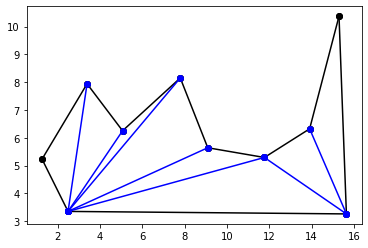

In [13]:
poly = [[1.25,5.23],
        [3.38,7.94], 
        [5.06,6.25],
        [7.79,8.15],
        [9.09,5.64],
        [11.77,5.29],
        [13.91,6.32],
        [15.30,10.37],
        [15.65,3.26],
        [2.48,3.35]]
triangulate(poly)

## No. 2

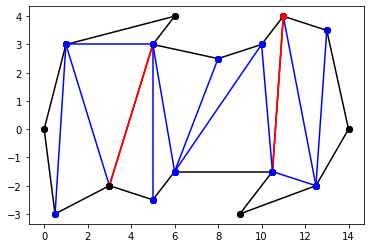

In [14]:
poly = [[0,0],
        [1,3],
        [6,4],
        [5,3],
        [8,2.5],
        [10,3],
        [11,4],
        [13,3.5],
        [14,0],
        [12.5,-2],
        [9,-3],
        [10.5,-1.5],
        [6,-1.5],
        [5,-2.5],
        [3,-2],
        [0.5,-3]]
        
triangulate(poly)

## No. 3

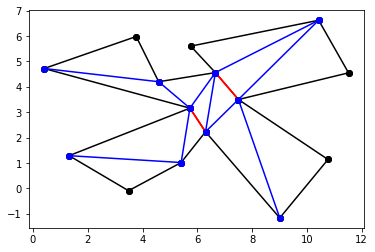

In [15]:
poly = [[ 0.41,  4.72],
        [ 3.77,  5.98],
        [ 4.59,  4.2 ],
        [ 6.66,  4.56],
        [ 5.76,  5.6 ],
        [10.43,  6.62],
        [11.52,  4.55],
        [ 7.5 ,  3.5 ],
        [10.77,  1.14],
        [ 9.01, -1.16],
        [ 6.3 ,  2.23],
        [ 5.41,  1.02],
        [ 3.49, -0.09],
        [ 1.32,  1.29],
        [ 5.73,  3.16]]
triangulate(poly)